In [1]:
Hyperparameters = {
    "gap": 10,
    "total_len": 100,
    "batch_size": 16,
    "dropout": 0.5,
    "d_model" : 64,
    "nhead" : 4,
    "num_layers" : 2,
    "dim_feedforward" : 256,
    "layer_norm_eps" : 1e-5,
    "learning_rate" : 1e-4,
    "weight_decay" : 1e-4,
    "epochs" : 10
}

In [2]:
print(Hyperparameters)

{'gap': 10, 'total_len': 100, 'batch_size': 16, 'dropout': 0.5, 'd_model': 64, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'layer_norm_eps': 1e-05, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'epochs': 10}


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
import math

file_paths = [
    "./Data/wind_speed_11_n.csv",
    "./Data/wind_speed_13_n.csv",
    "./Data/wind_speed_15_n.csv",
    "./Data/wind_speed_17_n.csv",
    "./Data/wind_speed_19_n.csv"
]

# Load datasets
datasets = [pd.read_csv(file) for file in file_paths]

In [ ]:
#datasets = [dataset.iloc[:int(0.1 * len(dataset))] for dataset in datasets] #To get as much of the data as you need

In [ ]:
# Define features and targets
features = ["Mx1", "Mx2", "Mx3", "My1", "My2", "My3", "Theta", "Vwx", "Vwy", "Vwz",
            "beta1", "beta2", "beta3", "dbeta1", "dbeta2", "dbeta3", "omega_r"]
targets = ["Mz1", "Mz2", "Mz3"]

train_data_x = []
train_data_y = []
val_data_x = []
val_data_y = []
test_data = {}

Hyperparameters['seq_len'] = Hyperparameters['total_len']//Hyperparameters['gap']

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

def create_sequences(data, targets, gap, total_len):
    X_seq, y_seq = [], []
    for i in range(len(data) - total_len + 1):
        X_seq.append(data[i + gap - 1 : i + total_len: gap])
        y_seq.append(targets[i + total_len - 1])
    return np.array(X_seq), np.array(y_seq)

# Split datasets
i = 0
for dataset in datasets:

    n = len(dataset)
    train_end_idx = int(0.6 * n)
    val_end_idx = int(0.8 * n)
    
    # Sequential splits
    train_segment = dataset.iloc[:train_end_idx]
    val_segment = dataset.iloc[train_end_idx:val_end_idx]
    test_segment = dataset.iloc[val_end_idx:]

    if i==0: #fit the scaler only on the first training set
      train_segment_x = scaler_x.fit_transform(train_segment[features].values)
      train_segment_y = scaler_y.fit_transform(train_segment[targets].values)

    else:
      train_segment_x = scaler_x.transform(train_segment[features].values)
      train_segment_y = scaler_y.transform(train_segment[targets].values)

    val_segment_x = scaler_x.transform(val_segment[features].values)
    val_segment_y = scaler_y.transform(val_segment[targets].values)

    train_seq_x,train_seq_y = create_sequences(train_segment_x, train_segment_y, Hyperparameters['gap'], Hyperparameters['total_len'])
    val_seq_x,val_seq_y = create_sequences(val_segment_x, val_segment_y, Hyperparameters['gap'], Hyperparameters['total_len'])

    # Append to lists
    train_data_x.append(train_seq_x)
    train_data_y.append(train_seq_y)
    val_data_x.append(val_seq_x)
    val_data_y.append(val_seq_y)
    test_data[i] = test_segment
    i += 1

train_data_x = np.concatenate(train_data_x, axis=0)
train_data_y = np.concatenate(train_data_y, axis=0)
val_data_x = np.concatenate(val_data_x, axis=0)
val_data_y = np.concatenate(val_data_y, axis=0)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(train_data_x, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data_y, dtype=torch.float32)
X_val_tensor = torch.tensor(val_data_x, dtype=torch.float32)
y_val_tensor = torch.tensor(val_data_y, dtype=torch.float32)

# Wrap tensors in DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=Hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Hyperparameters['batch_size'], shuffle=False)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.encoding[:, 0::2] = torch.sin(positions * div_term)
        self.encoding[:, 1::2] = torch.cos(positions * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
      # Add positional encoding to input
      x = x + self.pe[:, :x.size(1), :]
      return x

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, d_model=512, nhead=8, num_layers=6, dim_feedforward = 2048, dropout=0.1, layer_norm_eps = 1e-5):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=seq_len)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers= num_layers, num_decoder_layers = num_layers, dim_feedforward = dim_feedforward, dropout = dropout, layer_norm_eps = layer_norm_eps, batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_embedding(x)  # Encode input to d_model dimensions
        x = self.positional_encoding(x)
        x = self.transformer(x, x)  # Apply transformer
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.dropout(x)
        x = self.linear1(x)  # Decode to target dimensions
        return x


input_dim = len(features)
output_dim = len(targets)

model = TransformerModel(input_dim=input_dim, output_dim=output_dim, seq_len=Hyperparameters['seq_len'], d_model = Hyperparameters['d_model'], nhead = Hyperparameters['nhead'], num_layers = Hyperparameters['num_layers'], dim_feedforward = Hyperparameters['dim_feedforward'] , dropout = Hyperparameters['dropout'], layer_norm_eps = Hyperparameters['layer_norm_eps'])

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=Hyperparameters['learning_rate'], weight_decay= Hyperparameters['weight_decay'])

early_stopping = EarlyStopping(patience=5, delta=0.00001)

Epoch 1/10, Train Loss: 0.0097, Val Loss: 0.0010
Epoch 2/10, Train Loss: 0.0029, Val Loss: 0.0010
Epoch 3/10, Train Loss: 0.0027, Val Loss: 0.0009
Epoch 4/10, Train Loss: 0.0025, Val Loss: 0.0010
Epoch 5/10, Train Loss: 0.0024, Val Loss: 0.0009
Epoch 6/10, Train Loss: 0.0024, Val Loss: 0.0009
Epoch 7/10, Train Loss: 0.0023, Val Loss: 0.0009
Epoch 8/10, Train Loss: 0.0023, Val Loss: 0.0008
Epoch 9/10, Train Loss: 0.0023, Val Loss: 0.0008
Epoch 10/10, Train Loss: 0.0022, Val Loss: 0.0008
{'gap': 10, 'total_len': 100, 'batch_size': 16, 'dropout': 0.5, 'd_model': 64, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'layer_norm_eps': 1e-05, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'epochs': 10, 'seq_len': 10}


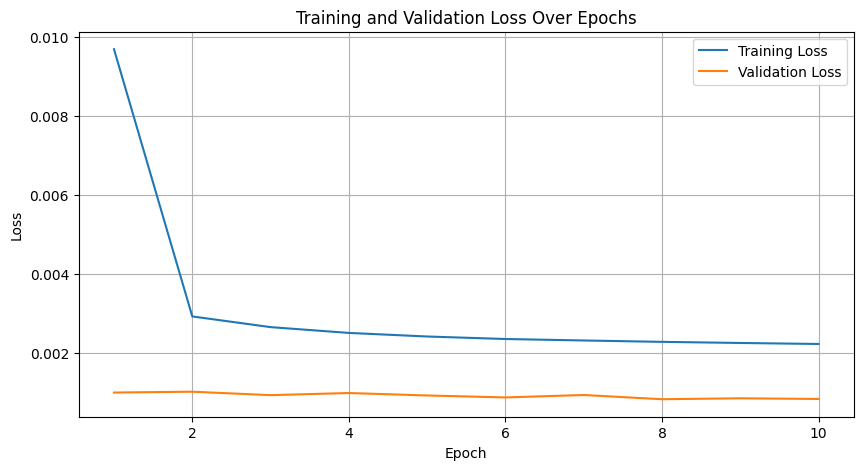

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
val_losses = []

epochs = Hyperparameters['epochs']
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store the training loss

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store the validation loss

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

print(Hyperparameters)
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save the Model
torch.save(model.state_dict(), "transformer_model.pth")
print("Model saved as transformer_model.pth")

Model saved as transformer_model.pth


<ipython-input-12-816ae16b358f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"/content/drive/MyDrive/colab-datasets/wind-turbines/trans

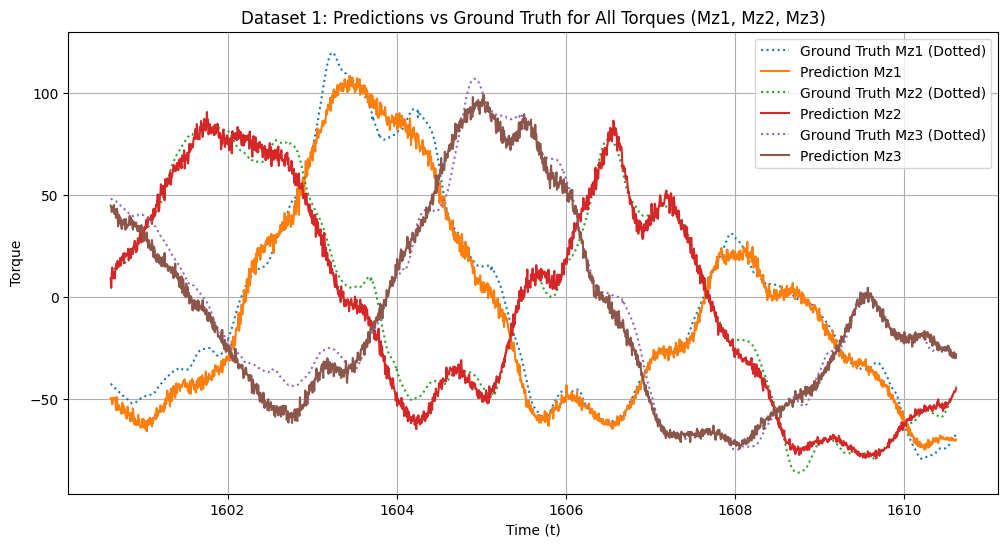

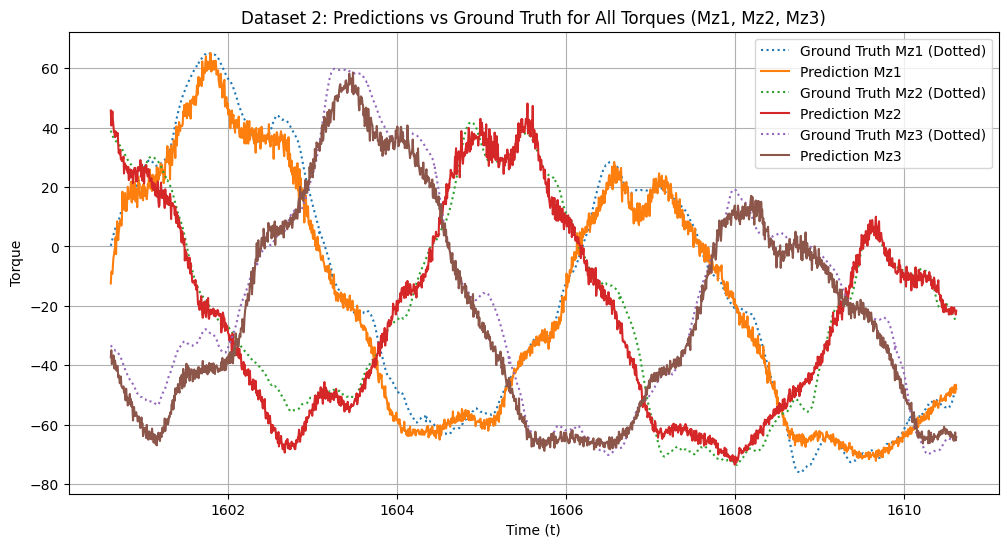

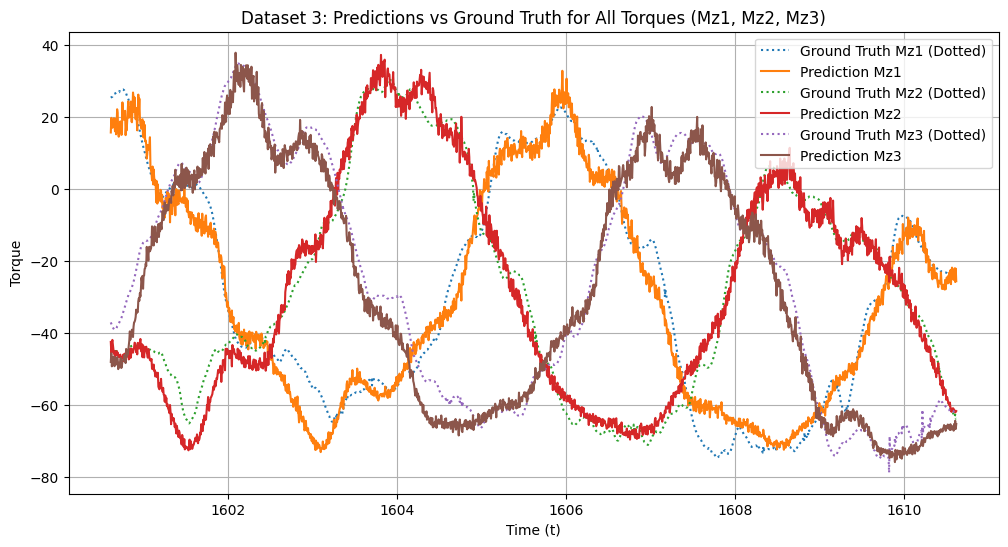

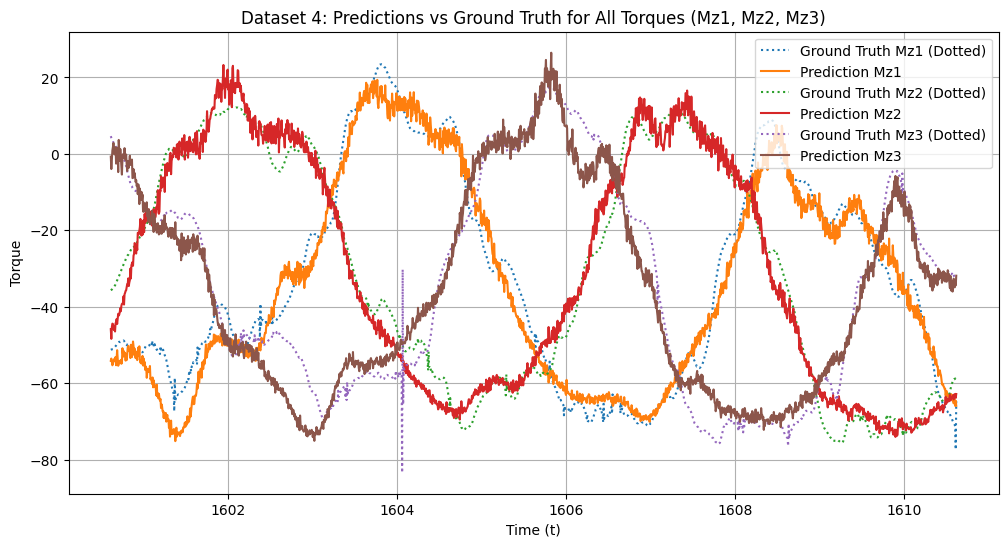

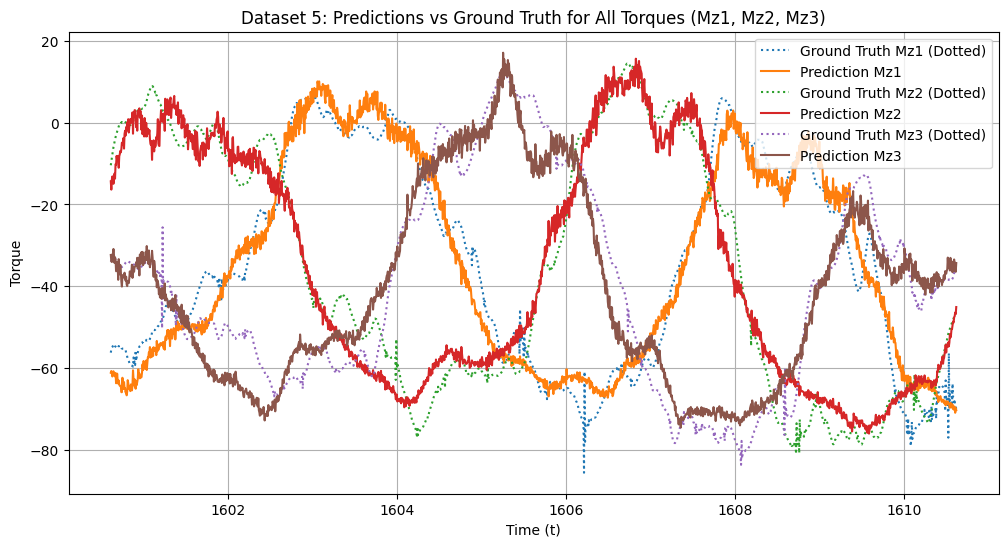

Mean Squared Error (MSE) for each dataset:
Dataset 1: 43.0458
Dataset 2: 41.5709
Dataset 3: 38.2874
Dataset 4: 37.8762
Dataset 5: 39.0457

Average MSE across all datasets: 39.9652


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

mse_per_dataset = {}
total_mse = 0
num_datasets = len(test_data)

i = 0
for test_df in test_data.values():

  # Load the validation dataset
  t_test = test_df["t"].values  # Extract the 't' column for plotting
  features_test = test_df.drop(["t", "Mz1", "Mz2", "Mz3"], axis=1).values  # Input features
  targets_test = test_df[["Mz1", "Mz2", "Mz3"]].values  # Ground truth for comparison

  # Preprocess the validation data
  features_test_scaled = scaler_x.transform(features_test)
  targets_test_scaled = scaler_y.transform(targets_test)
  X_test, y_test = create_sequences(features_test_scaled, targets_test_scaled, Hyperparameters['gap'], Hyperparameters['total_len'])  # Sequence preparation

  # Generate predictions
  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
      X_test_tensor = X_test_tensor.to(device)
      y_test_pred = model(X_test_tensor).cpu().numpy()  # Predictions from the model

  # Align `t` for plotting
  # Since the sequences shorten the dataset, align 't' with the predictions
  t_test_aligned = t_test[Hyperparameters['total_len'] - 1:]  # Remove the first `total_len - 1` timesteps to match the predictions
  target_test = targets_test[Hyperparameters['total_len'] - 1:]
  # Plot results
  inversed_pred = scaler_y.inverse_transform(y_test_pred)
  inversed_true = scaler_y.inverse_transform(y_test)
  mse = mean_squared_error(inversed_true, inversed_pred)
  mse_per_dataset[f"Dataset {i+1}"] = mse
  total_mse += mse

    # get only the first 1600 examples for a more cohesive plot
  max_examples = 1600
  t_test_aligned_plot = t_test_aligned[:max_examples]
  target_test_plot = target_test[:max_examples]
  inversed_pred_plot = inversed_pred[:max_examples]

  plt.figure(figsize=(12, 6))
  for j, target_name in enumerate(["Mz1", "Mz2", "Mz3"]):
      plt.plot(t_test_aligned_plot, target_test_plot[:, j], label=f"Ground Truth {target_name} (Dotted)", linestyle="dotted")
      plt.plot(t_test_aligned_plot, inversed_pred_plot[:, j], label=f"Prediction {target_name}")

  plt.xlabel("Time (t)")
  plt.ylabel("Torque")
  plt.title(f"Dataset {i+1}: Predictions vs Ground Truth for All Torques (Mz1, Mz2, Mz3)")
  plt.legend()
  plt.grid()
  plt.show()

  i += 1

print("Mean Squared Error (MSE) for each dataset:")
for dataset, mse in mse_per_dataset.items():
    print(f"{dataset}: {mse:.4f}")

average_mse = total_mse / num_datasets
print(f"\nAverage MSE across all datasets: {average_mse:.4f}")
